In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import nltk
from pandas.api.types import is_numeric_dtype
import seaborn as sns
from datetime import timedelta
import glob
from langdetect import detect_langs
import sys
import multiprocessing as mp
from statsmodels.tsa.seasonal import seasonal_decompose
import re
import os
from scipy import stats
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

%matplotlib inline

In [2]:
df = pd.DataFrame()
for file in glob.iglob('/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/*pickle'):
    print(file)
    df_temp = pd.read_pickle(file)
    df = pd.concat([df,df_temp],axis=0)
    print(len(df_temp),len(df))

/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/125672_16.pickle
19355 19355
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/50513_19.pickle
496 19851
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/172827_15.pickle
8206 28057
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/230576_13.pickle
11043 39100
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/125714_16.pickle
17441 56541
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/32463_19.pickle
12908 69449
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/49150_19.pickle
1874 71323
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/221808_13.pickle
19776 91099
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/309346_11.pickle
8046 99145
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/190201_14.pickle
18830 117975
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/241777_13.pickle
367 118342
/media/daniel/m2ssd/ulm_parkhaus_forecast/pickles/events/19021

In [15]:
df['parkhaus'] = df['parkhaus'].astype("int")

In [3]:
#df = pd.read_csv('/home/daniel/training_data/serie-a/transport-data.csv',header=0)

dist_names = [
    'anglit', 'arcsine', 'argus', 'beta', 'betaprime', 'bradford', 'burr', 'burr12',
    'cauchy', 'chi', 'chi2', 'cosine', 'crystalball', 'dgamma', 'dweibull', 'erlang', 'expon',
    'exponnorm', 'exponpow', 'exponweib', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm',
    'frechet_l', 'frechet_r', 'gamma', 'gausshyper', 'genexpon', 'genextreme', 'gengamma',
    'genhalflogistic', 'geninvgauss', 'genlogistic', 'gennorm', 'genpareto', 'gilbrat', 'gompertz',
    'gumbel_l', 'gumbel_r', 'halfcauchy', 'halfgennorm', 'halflogistic', 'halfnorm',
    'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kappa3', 'kappa4',
    'ksone', 'kstwo', 'kstwobign', 'laplace', 'levy', 'levy_l', 'levy_stable', 'loggamma', 'logistic',
    'loglaplace', 'lognorm', 'loguniform', 'lomax', 'maxwell', 'mielke', 'moyal', 'nakagami', 'ncf', 'nct', 'ncx2',
    'norm', 'norminvgauss', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rayleigh',
    'rdist', 'recipinvgauss', 'reciprocal', 'rice', 'rv_continuous', 'rv_histogram', 'semicircular',
    'skewnorm', 't', 'trapz', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises',
    'vonmises_line', 'wald', 'weibull_max', 'weibull_min', 'wrapcauchy'
]
discrete_distri = [
    'bernoulli','betabinom','binom','boltzmann','dlaplace','geom','hypergeom','logser',
    'nbinom','nchypergeom_fisher','nchypergeom_wallenius','nhypergeom','planck',
    'poisson','randint','skellam','yulesimon','zipf','zipfian'
]

In [4]:
df.head(2)

,uuid,einfahrt,ausfahrt,aufenthalt,parkhaus
0,9E2E4B00-A729-4C72-AF75-CC58DE750D8C,2016-01-01 00:03:14,2016-01-01 06:15:18,22324,3
1,27CD1822-EA1C-46C3-BFAF-86093FAD9FB7,2016-01-01 00:09:07,2016-01-01 03:48:28,13161,3


In [5]:
df['einfahrt'].min()

Timestamp('2010-09-15 09:46:25')

In [6]:
df['einfahrt'].max()

Timestamp('2022-12-31 23:17:00')

In [6]:
df

,uuid,einfahrt,ausfahrt,aufenthalt,parkhaus
0,9E2E4B00-A729-4C72-AF75-CC58DE750D8C,2016-01-01 00:03:14,2016-01-01 06:15:18,22324,3
1,27CD1822-EA1C-46C3-BFAF-86093FAD9FB7,2016-01-01 00:09:07,2016-01-01 03:48:28,13161,3
2,17EB2FC7-DDDF-4D34-89A1-30CA8CC8659A,2016-01-01 00:13:57,2016-01-01 01:16:27,3750,3
3,507E25E5-D76F-4E0A-ABC3-C92B332D0BE6,2016-01-01 00:26:57,2016-01-01 00:35:03,486,3
4,35B09EB9-0842-4E4C-AFA6-1371528A0B88,2016-01-01 00:29:53,2016-01-01 15:15:47,53154,3
...,...,...,...,...,...
618,941009DC-B7FB-411A-BA63-8891E265970A,2021-09-25 15:59:14,2021-09-25 16:15:32,978,9
619,B492E0E1-A647-4F92-AE6A-0ACE0C10AF19,2021-09-25 17:01:17,2021-09-25 23:56:52,24935,9
620,0B2AF5BB-C930-401C-B686-E8453B653077,2021-09-25 17:23:34,2021-09-25 17:25:20,106,9
621,86F6870F-2D75-4828-90E7-800572C3827B,2021-09-25 18:43:02,2021-09-25 21:54:28,11486,9


In [8]:
df['parkhaus'] = df['parkhaus'].astype(int)

In [17]:
from dateutil.parser import parse

df_types = pd.DataFrame()

for col in df.columns:
    kind = df[col].dtype.kind
    if(kind in 'biufc'):
        print(col,"numeric")
        df_types = df_types._append({
            'type': 'numeric',
            'specification': df[col].dtype.name,
            'attribute': col
        },ignore_index=True)
    elif(kind in 'M'):
        df_types = df_types._append({
            'type': 'date/time',
            'specification': 'date/time',
            'attribute': col
        },ignore_index=True)
    elif(kind in 'O'):
        isDate = 0
        try:
            pd.to_datetime(df[col])
            isDate=1
        except:
            print("casting to date failed for",col)
        if(isDate == 1):
            df_types = df_types._append({
                'type': 'date/time',
                'specification': 'date/time',
                'attribute': col
            },ignore_index=True)
            print(col,"date/datetime")
        else:
            df_types = df_types._append({
                'type': 'string',
                'specification': 'string',
                'attribute': col
            },ignore_index=True)
            print(col,"string")

pd.to_pickle(df_types,'/media/daniel/m2ssd/nitd/pbg-df_types.pickle')
df_types.to_excel("/media/daniel/m2ssd/nitd/pbg-df_types.xlsx")

casting to date failed for uuid
uuid string
aufenthalt numeric
parkhaus numeric


<ipython-input-17-d5f2d00f9f61>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[col])


In [15]:
df['einfahrt'].dtypes.kind

'M'

In [9]:
df.head(2)

,uuid,einfahrt,ausfahrt,aufenthalt,parkhaus
0,9E2E4B00-A729-4C72-AF75-CC58DE750D8C,2016-01-01 00:03:14,2016-01-01 06:15:18,22324,3
1,27CD1822-EA1C-46C3-BFAF-86093FAD9FB7,2016-01-01 00:09:07,2016-01-01 03:48:28,13161,3


In [18]:
df_types

,type,specification,attribute
0,string,string,uuid
1,date/time,date/time,einfahrt
2,date/time,date/time,ausfahrt
3,numeric,int64,aufenthalt
4,numeric,int64,parkhaus


In [17]:
df_types[df_types['type']=='date/time']

,type,specification,attribute
1,date/time,date/time,einfahrt
2,date/time,date/time,ausfahrt


In [18]:
df_time_density = pd.DataFrame()

for idx,row in df_types[df_types['type']=='date/time'].iterrows():
    print(row['attribute'])
    df[row['attribute']+'_dt'] = pd.to_datetime(df[row['attribute']])
    df.index = df[row['attribute']+'_dt']
    for density in ['s','min','h','d']:
        values = np.unique(list(df[row['attribute']+'_dt'].resample('s').count()))
        stableDensity = 0
        if(len(values) == 1):
            stableDensity = 1
        df_time_density = df_time_density._append({
            'freq': density,
            'stable': stableDensity,
            'different abundancies': len(values),
            'abundancies': values,
            'attribute': row['attribute']
        },ignore_index=True)
pd.to_pickle(df_time_density,'/media/daniel/m2ssd/nitd/pbg-df_time_density.pickle')
df_time_density.to_excel("/media/daniel/m2ssd/nitd/pbg-df_time_density.xlsx")

einfahrt
ausfahrt


In [20]:
df

,uuid,einfahrt,ausfahrt,aufenthalt,parkhaus,einfahrt_dt,ausfahrt_dt
ausfahrt_dt,,,,,,,
2016-01-01 06:15:18,9E2E4B00-A729-4C72-AF75-CC58DE750D8C,2016-01-01 00:03:14,2016-01-01 06:15:18,22324,3,2016-01-01 00:03:14,2016-01-01 06:15:18
2016-01-01 03:48:28,27CD1822-EA1C-46C3-BFAF-86093FAD9FB7,2016-01-01 00:09:07,2016-01-01 03:48:28,13161,3,2016-01-01 00:09:07,2016-01-01 03:48:28
2016-01-01 01:16:27,17EB2FC7-DDDF-4D34-89A1-30CA8CC8659A,2016-01-01 00:13:57,2016-01-01 01:16:27,3750,3,2016-01-01 00:13:57,2016-01-01 01:16:27
2016-01-01 00:35:03,507E25E5-D76F-4E0A-ABC3-C92B332D0BE6,2016-01-01 00:26:57,2016-01-01 00:35:03,486,3,2016-01-01 00:26:57,2016-01-01 00:35:03
2016-01-01 15:15:47,35B09EB9-0842-4E4C-AFA6-1371528A0B88,2016-01-01 00:29:53,2016-01-01 15:15:47,53154,3,2016-01-01 00:29:53,2016-01-01 15:15:47
...,...,...,...,...,...,...,...
2021-09-25 16:15:32,941009DC-B7FB-411A-BA63-8891E265970A,2021-09-25 15:59:14,2021-09-25 16:15:32,978,9,2021-09-25 15:59:14,2021-09-25 16:15:32
2021-09-25 23:56:52,B492E0E1-A647-4F92-AE6A-0ACE0C10AF19,2021-09-25 17:01:17,2021-09-25 23:56:52,24935,9,2021-09-25 17:01:17,2021-09-25 23:56:52
2021-09-25 17:25:20,0B2AF5BB-C930-401C-B686-E8453B653077,2021-09-25 17:23:34,2021-09-25 17:25:20,106,9,2021-09-25 17:23:34,2021-09-25 17:25:20


In [21]:
df[df.index.duplicated()]

,uuid,einfahrt,ausfahrt,aufenthalt,parkhaus,einfahrt_dt,ausfahrt_dt
ausfahrt_dt,,,,,,,
2016-01-01 00:35:03,4D26076C-FEAF-4118-B4BC-1EBB80F1431E,2016-01-01 00:33:37,2016-01-01 00:35:03,86,3,2016-01-01 00:33:37,2016-01-01 00:35:03
2016-01-01 21:31:09,1E53BC84-7742-4CE1-9354-6DC43C7EE3F8,2016-01-01 18:44:44,2016-01-01 21:31:09,9985,3,2016-01-01 18:44:44,2016-01-01 21:31:09
2016-01-01 22:27:40,9DA9CF32-E67C-4E6D-8714-EDDB6F027F37,2016-01-01 19:23:24,2016-01-01 22:27:40,11056,3,2016-01-01 19:23:24,2016-01-01 22:27:40
2016-01-02 12:38:56,473FD7E9-2D9A-479B-AA3F-D707A6360A92,2016-01-02 09:49:01,2016-01-02 12:38:56,10195,3,2016-01-02 09:49:01,2016-01-02 12:38:56
2016-01-02 10:52:19,D5D6F725-F1CD-4851-AA99-E957372AE259,2016-01-02 09:55:15,2016-01-02 10:52:19,3424,3,2016-01-02 09:55:15,2016-01-02 10:52:19
...,...,...,...,...,...,...,...
2021-09-24 22:17:15,3BBE8D90-3A9C-4E06-8B23-3A65BC8140EB,2021-09-24 19:02:42,2021-09-24 22:17:15,11673,9,2021-09-24 19:02:42,2021-09-24 22:17:15
2021-09-24 22:40:57,C96A8796-ADEC-4C3A-8C52-B53627A9F32F,2021-09-24 19:03:02,2021-09-24 22:40:57,13075,9,2021-09-24 19:03:02,2021-09-24 22:40:57
2021-09-24 22:12:13,F32AF8BB-92FC-410D-8B77-818B98E18555,2021-09-24 19:09:04,2021-09-24 22:12:13,10989,9,2021-09-24 19:09:04,2021-09-24 22:12:13


In [23]:
df_ts_gaps = pd.DataFrame()

df.reset_index(inplace=True,drop=True)
for idx,row in df_types[df_types['type']=='date/time'].iterrows():
    print(row['attribute'])
    #df[row['attribute']+'_dt'] = pd.to_datetime(df[row['attribute']])
    for density in ['1 second','1 minute','1 hour','1 day']:
        print(density)
        df[row['attribute']+'_gap'] = df[row['attribute']+'_dt'].sort_values().diff() > pd.to_timedelta(density)
        gaps = len(df[df[row['attribute']+'_gap']==True])
        df_ts_gaps = df_ts_gaps._append({
            'freq': density,
            'attribute': row['attribute'],
            'gaps': gaps
        },ignore_index=True)
        print(row['attribute'],density,gaps)
pd.to_pickle(df_ts_gaps,'/media/daniel/m2ssd/nitd/pbg-df_ts_gaps.pickle')
df_ts_gaps.to_excel("/media/daniel/m2ssd/nitd/pbg-df_ts_gaps.xlsx")

einfahrt
1 second
einfahrt 1 second 25938123
1 minute
einfahrt 1 minute 548084
1 hour
einfahrt 1 hour 5792
1 day
einfahrt 1 day 2
ausfahrt
1 second
ausfahrt 1 second 26154983
1 minute
ausfahrt 1 minute 638672
1 hour
ausfahrt 1 hour 3168
1 day
ausfahrt 1 day 2


In [9]:
#check auf vollstaendigkeit
df_complete = pd.DataFrame()

for col in df.columns:
    missingcount = 0
    hasMissingValues = False
    if(df[col].isnull().values.any()):
        missingcount = df[col].isnull().sum()
        hasMissingValues = True

    df_complete = df_complete._append({
        'attribute': col,
        'hasMissingValues': hasMissingValues,
        'countMissingValues': missingcount
    },ignore_index=True)

pd.to_pickle(df_complete,'/media/daniel/m2ssd/nitd/pbg-missingvalues.pickle')
df_complete.to_excel("/media/daniel/m2ssd/nitd/pbg-missingvalues.xlsx")

In [ ]:
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

In [ ]:
get_common_distributions()

['cauchy',
 'chi2',
 'expon',
 'exponpow',
 'gamma',
 'lognorm',
 'norm',
 'powerlaw',
 'rayleigh',
 'uniform']

In [12]:
df_types

,type,specification,attribute
0,string,string,uuid
1,date/time,date/time,einfahrt
2,date/time,date/time,ausfahrt
3,numeric,int64,aufenthalt
4,string,string,parkhaus


no. cols before dropping entirely empty cols 2
no. cols after dropping entirely empty cols 2


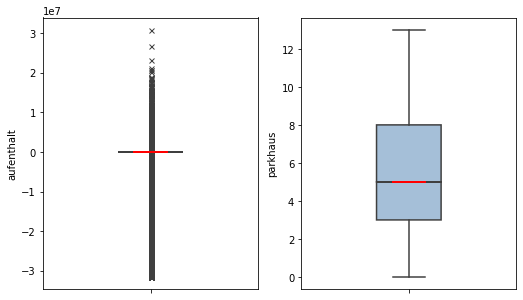

In [23]:
#ermittle outlier
df_outlier = pd.DataFrame()

fig = plt.figure(figsize=(10,5))
df3_numerics=df[list(df_types[df_types['type']=='numeric']['attribute'])]
print("no. cols before dropping entirely empty cols",len(df3_numerics.columns))
df3_numerics = df3_numerics.drop(list(df_complete[(df_complete['hasMissingValues']==True) & (df_complete['countMissingValues']==len(df))]['attribute']),axis=1)
print("no. cols after dropping entirely empty cols",len(df3_numerics.columns))

for i,column in enumerate(df3_numerics,1):
    #perc
    upperP = df[column].quantile(0.99)
    lowerP = df[column].quantile(0.01)
    outliercountP = len(df[
        (df[column] > upperP) |
        (df[column] < lowerP)
    ])

    #zscore
    upperZ = df[column].mean() + 3* df[column].std()
    lowerZ = df[column].mean() - 3* df[column].std()
    outliercountZ = len(df[
        (df[column] > upperZ) |
        (df[column] < lowerZ)
    ])

    #iqr
    p25 = df[column].quantile(0.25)
    p75 = df[column].quantile(0.75)
    iqr = p75 - p25
    upperI = p75 + 1.5 * iqr
    lowerI = p25 - 1.5 * iqr
    outliercountI = len(df[
        (df[column] > upperI) |
        (df[column] < lowerI)
    ])
    df_outlier = df_outlier._append({
        'attribute': column,
        'upper quantile': round(upperP,2),
        'lower quantile': round(lowerP,2),
        'count q': round(outliercountP,2),
        'upper zscore': round(upperZ,2),
        'lower zscore': round(lowerZ,2),
        'count zscore': round(outliercountZ,2),
        'upper iqr': round(upperI,2),
        'lower iqr': round(lowerI,2),
        #'iqr p25': round(p25,2),
        #'iqr p75': round(p75,2),
        'iqr': round(iqr,2),
        'count iqr': outliercountI
    },ignore_index=True)
    plt.subplot(
        int(np.ceil(len(df3_numerics.columns)/4)),
        4,
        i
    )
    plt.subplots_adjust(right=1.5)
    sns.boxplot(
        data=df, y=column,
        notch=True, showcaps=True,
        width=0.3,
        flierprops={"marker": "x"},
        boxprops={"facecolor": (.3, .5, .7, .5)},
        medianprops={"color": "r", "linewidth": 2},
    )

pd.to_pickle(df_outlier,'/media/daniel/m2ssd/nitd/pbg-df_outlier.pickle')
df_outlier.to_excel("/media/daniel/m2ssd/nitd/pbg-df_outlier.xlsx")

In [9]:
df_numerics[column][:1000000]

0        22324
1        13161
2         3750
3          486
4        53154
         ...  
12536       53
12537     5138
12538     4206
12539     7709
12540     8002
Name: aufenthalt, Length: 1000000, dtype: int64

In [10]:
def processEntry(colsToProcess):

    global df_numerics
    df_numeric_distribution = pd.DataFrame()

    for column in colsToProcess:

        colvals = df_numerics[column][:1000000].values
        f = Fitter(
            colvals,
            distributions=dist_names,
            timeout=120
        )
        f.fit(
            n_jobs=15,
            max_workers=15,
            progress=False
        )
        try:
            bestDistributionType = list(f.get_best(method = 'sumsquare_error'))[0]
        except:
            continue
        print(i,column,bestDistributionType)
        df_numeric_distribution = df_numeric_distribution._append({
            'column': column,
            'distribution': bestDistributionType,
            'n_unique': len(df_numerics[column].unique())
            },ignore_index=True
        )
        pd.to_pickle(df_numeric_distribution,'/media/daniel/m2ssd/nitd/pbg-df_numeric_distribution_'+str(os.getpid())+'.pickle')

In [11]:
df_numeric_distributions = pd.DataFrame()
df_numerics=df[list(df_types[df_types['type']=='numeric']['attribute'])]

colsToProcess = []
for i,column in enumerate(df_numerics,1):
    if(len(df_numerics[column].unique()) == len(df_numerics)):
        df_numeric_distributions = df_numeric_distributions._append({
            'column': column,
            'distribution': 'None',
            'n_unique': len(df_numerics[column].unique())
            },ignore_index=True
        )
        print("no countplot for",column,"only unique numeric values")
        continue
    colsToProcess.append(column)

para=1
workspace = np.array_split(colsToProcess,para)
print("len workspace: "+str(len(workspace)))

pool_obj = mp.Pool(para)
resultsConversion = pool_obj.map(processEntry,workspace)

len workspace: 1


SKIPPED frechet_l distribution (taking more than 120 seconds)
SKIPPED frechet_r distribution (taking more than 120 seconds)
SKIPPED argus distribution (taking more than 120 seconds)
SKIPPED beta distribution (taking more than 120 seconds)
SKIPPED burr12 distribution (taking more than 120 seconds)
SKIPPED burr distribution (taking more than 120 seconds)
SKIPPED crystalball distribution (taking more than 120 seconds)
SKIPPED exponweib distribution (taking more than 120 seconds)
SKIPPED f distribution (taking more than 120 seconds)
SKIPPED fatiguelife distribution (taking more than 120 seconds)
SKIPPED fisk distribution (taking more than 120 seconds)
SKIPPED foldcauchy distribution (taking more than 120 seconds)
SKIPPED gausshyper distribution (taking more than 120 seconds)
SKIPPED genextreme distribution (taking more than 120 seconds)
SKIPPED gengamma distribution (taking more than 120 seconds)
SKIPPED genhalflogistic distribution (taking more than 120 seconds)
SKIPPED geninvgauss distri

1 aufenthalt exponnorm


In [12]:
df_numeric_distributions

""


In [13]:
#numeric excel erzeugen

for file in glob.glob('/media/daniel/m2ssd/nitd/pbg-df_numeric_distribution_*pickle'):
    df_temp = pd.read_pickle(file)
    df_numeric_distributions = pd.concat([df_numeric_distributions,df_temp],axis=0)
    print(file,len(df_temp),len(df_numeric_distributions))

df_numeric_distributions.to_excel("/media/daniel/m2ssd/nitd/pbg-df_numeric_distribution.xlsx")

/media/daniel/m2ssd/nitd/pbg-df_numeric_distribution_148192.pickle 1 1


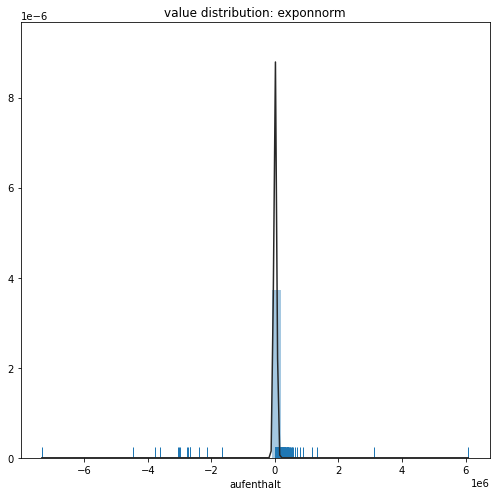

In [19]:
import matplotlib.ticker as ticker

fig, ax =plt.subplots(
    1,1,
    figsize=(7,7),
    tight_layout=True#, gridspec_kw={'height_ratios': [1, 1]}
)

row = 0
col = 0
for i,column in enumerate(df_numeric_distributions[df_numeric_distributions['distribution']!='None']['column'].values):
    bestDistributionType = df_numeric_distributions[df_numeric_distributions['column']==column]['distribution'].values[0]
    bestDistributionTypeStatsCall = getattr(stats,bestDistributionType)
    sns.distplot(
        df_numerics[column][:100000],
        kde=False,
        rug=True,
        fit=bestDistributionTypeStatsCall
    ).set_title('value distribution: '+bestDistributionType)

    if(col == 3):
        col = 0
        row += 1
    else:
        col += 1

In [20]:
df_numeric_distributions

,column,distribution,n_unique
0,Delivery-NUTS-2-Lat,rdist,38
1,Delivery-NUTS-2-Lon,foldnorm,38
2,Pickup-NUTS-3-Lat,johnsonsb,253
0,Luftlinie in KM,gausshyper,701
1,Entfernung,gausshyper,960
2,KM-Preis,beta,26
0,Delivery-Cluster,johnsonsb,10
1,Delivery-ClusterLat,weibull_max,10
2,Delivery-ClusterLon,dweibull,10
0,loadingMeters,johnsonsu,6


In [31]:
df.columns

Index(['key', 'externalReference', 'order_date', 'loadingMeters', 'weightKg',
       'price', 'pickupCity', 'pickupCountry', 'pickupStreet',
       'pickupDateTime', 'pickupZipCode', 'pickupName', 'pickupLat',
       'pickupLon', 'key.1', 'deliveryCity', 'deliveryCountry',
       'deliveryStreet', 'deliveryDateTime', 'deliveryZipCode', 'deliveryName',
       'deliveryLat', 'deliveryLon', 'departmentKey', 'customerKey',
       'volumeM3', 'product', 'type', 'days', 'time', 'service',
       'Luftlinie in KM', 'Entfernung', 'KM-Preis', 'Carrier', 'CarrierName',
       'Shipper', 'ShipperName', 'revenue_total', 'revenue_transport',
       'revenue_toll', 'cost_total', 'cost_transport', 'cost_toll',
       'unit_revenue', 'unit_cost', 'gestellung', 'ankunft', 'Pickup-Cluster',
       'Pickup-ClusterLat', 'Pickup-ClusterLon', 'Delivery-Cluster',
       'Delivery-ClusterLat', 'Delivery-ClusterLon', 'Pickup-NUTS-1-Name',
       'Pickup-NUTS-1-ID', 'Pickup-NUTS-1-Lat', 'Pickup-NUTS-1-Lon',
   

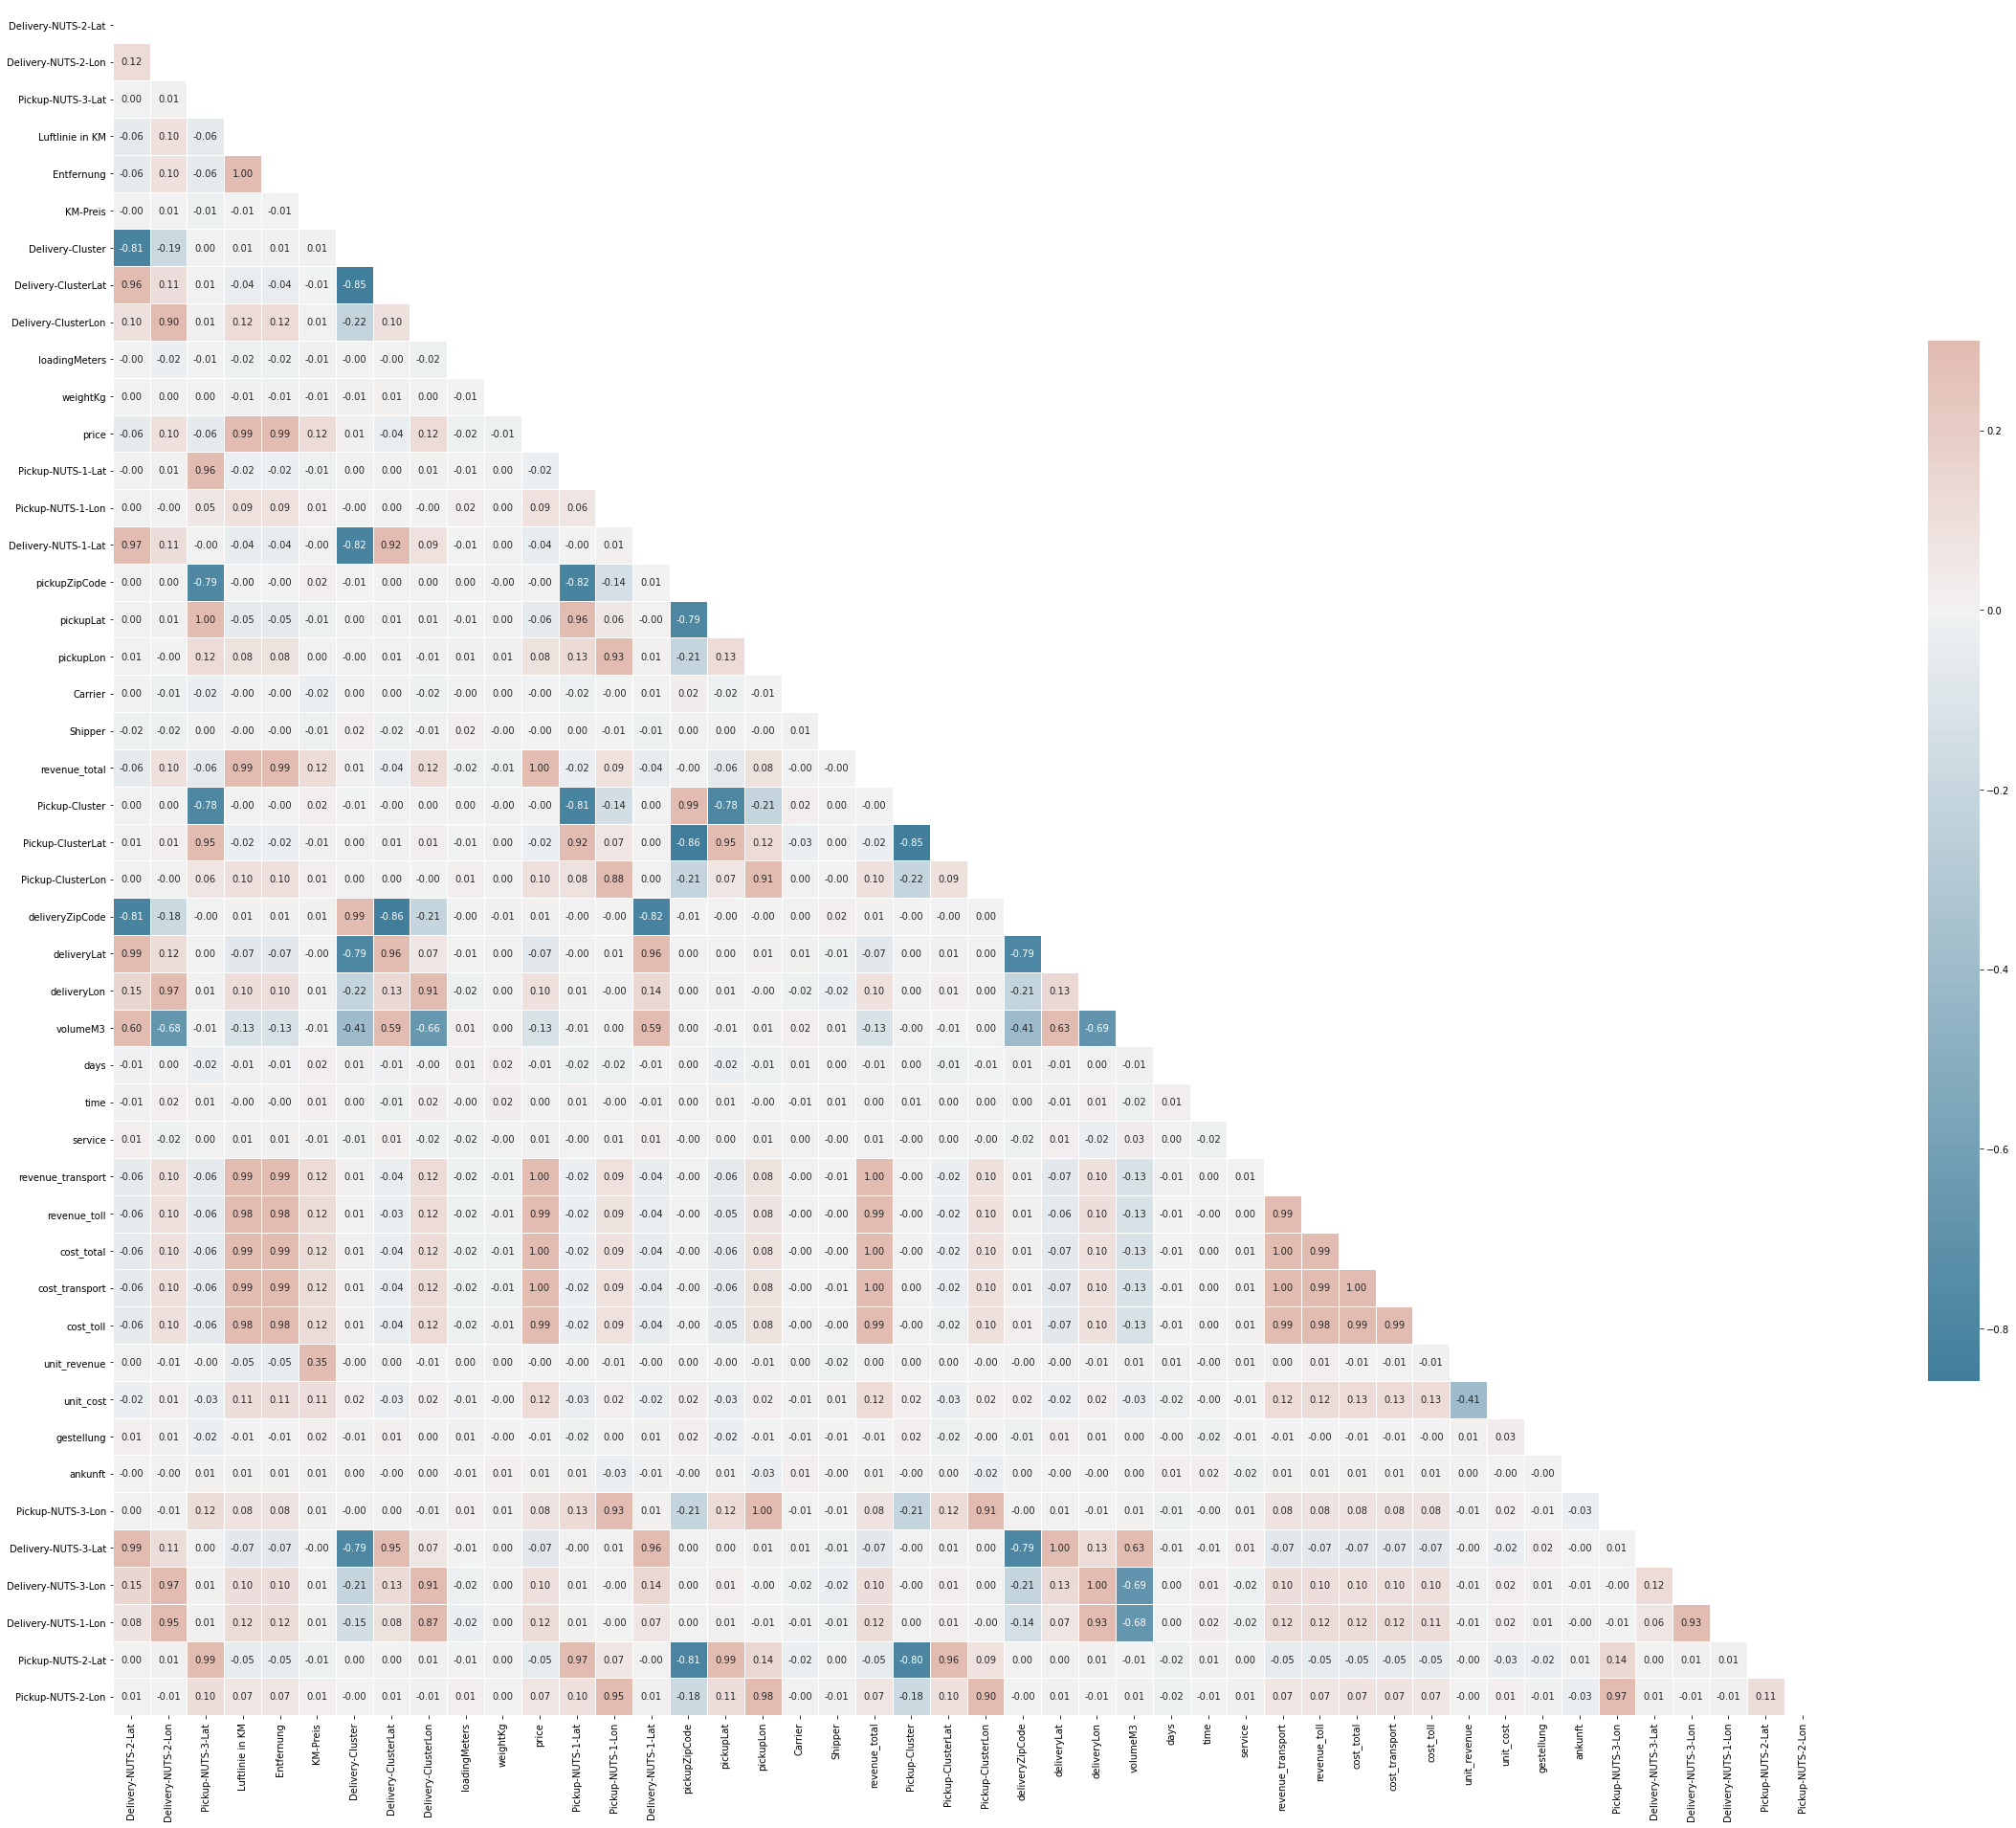

In [49]:
#exclude the ones with only unique values
df_corr = df[df_numeric_distributions['column'].values.tolist()]
corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 40))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, fmt=".2f", cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr.to_excel("/media/daniel/m2ssd/nitd/seriea-corr.xlsx")


In [78]:
df_lang = pd.DataFrame()

for column in df_types[df_types['type']=='string']['attribute'].values.tolist():
    langArr = str(detect_langs(" ".join(df[column].values.tolist()))[0]).split(':')
    df_lang = df_lang._append({
        'column': column,
        'lang': langArr[0],
        'proba': langArr[1]
    },ignore_index=True)
df_lang.to_excel("/media/daniel/m2ssd/nitd/seriea-languages.xlsx")


In [7]:
df_types[df_types['type']=='date/time']

,type,specification,attribute
2,date/time,date/time,order_date
9,date/time,date/time,pickupDateTime
18,date/time,date/time,deliveryDateTime


In [100]:
len(df_types[df_types['type']=='numeric'])

49

In [20]:
df.head(2)

,uuid,einfahrt,ausfahrt,aufenthalt,parkhaus
0,9E2E4B00-A729-4C72-AF75-CC58DE750D8C,2016-01-01 00:03:14,2016-01-01 06:15:18,22324,3
1,27CD1822-EA1C-46C3-BFAF-86093FAD9FB7,2016-01-01 00:09:07,2016-01-01 03:48:28,13161,3


In [9]:
df_temp = pd.DataFrame(df[['aufenthalt','einfahrt']])
#df_temp['order_date'] = df_temp['order_date'].apply(lambda x: re.sub('T', ' ',x))
df_temp['einfahrt'] = pd.to_datetime(df_temp['einfahrt'])
df_temp = df_temp.sort_values(by='einfahrt',ascending=True)
df_temp

,aufenthalt,einfahrt
0,7994,2010-09-15 09:46:25
1,6781,2010-09-15 09:46:55
2,8349,2010-09-15 09:47:28
3,4544,2010-09-15 09:47:40
4,5595,2010-09-15 09:47:56
...,...,...
103305,2132,2022-12-31 22:40:53
103306,2841,2022-12-31 22:52:16
50027,1598,2022-12-31 22:55:00
39896,1686,2022-12-31 22:56:07


In [10]:
#https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-period-aliases
#https://pandas.pydata.org/docs/reference/api/pandas.tseries.offsets.DateOffset.html
pd.options.mode.chained_assignment = None
df_temp['ts_s'] = df_temp['einfahrt'].dt.to_period('S').dt.to_timestamp()
df_temp['ts_m'] = df_temp['einfahrt'].dt.to_period('min').dt.to_timestamp()
df_temp['ts_h'] = df_temp['einfahrt'].dt.to_period('H').dt.to_timestamp()
df_temp['ts_d'] = df_temp['einfahrt'].dt.to_period('D').dt.to_timestamp()
df_temp['ts_w'] = df_temp['einfahrt'].dt.to_period('W').dt.to_timestamp()
df_temp['ts_mt'] = df_temp['einfahrt'].dt.to_period('M').dt.to_timestamp()
df_temp['ts_y'] = df_temp['einfahrt'].dt.to_period('Y').dt.to_timestamp()

df_temp['ts_s_previous'] = df_temp['ts_s'].shift(1)
df_temp['ts_m_previous'] = df_temp['ts_m'].shift(1)
df_temp['ts_h_previous'] = df_temp['ts_h'].shift(1)
df_temp['ts_d_previous'] = df_temp['ts_d'].shift(1)
df_temp['ts_w_previous'] = df_temp['ts_w'].shift(1)
df_temp['ts_mt_previous'] = df_temp['ts_mt'].shift(1)
df_temp['ts_y_previous'] = df_temp['ts_y'].shift(1)

df_temp['ts_s_next'] = df_temp['ts_s_previous'] + pd.DateOffset(seconds=1)
df_temp['ts_m_next'] = df_temp['ts_m_previous'] + pd.DateOffset(minutes=1)
df_temp['ts_h_next'] = df_temp['ts_h_previous'] + pd.DateOffset(hours=1)
df_temp['ts_d_next'] = df_temp['ts_d_previous'] + pd.DateOffset(days=1)
df_temp['ts_w_next'] = df_temp['ts_w_previous'] + timedelta(weeks=1)
df_temp['ts_mt_next'] = df_temp['ts_mt_previous'] + pd.DateOffset(months=1)
df_temp['ts_y_next'] = df_temp['ts_y_previous'] + pd.DateOffset(years=1)

df_temp = df_temp[1:]

gs = df_temp[(df_temp['ts_s']!=df_temp['ts_s_previous']) & (df_temp['ts_s']!=df_temp['ts_s_next'])]
gm = df_temp[(df_temp['ts_m']!=df_temp['ts_m_previous']) & (df_temp['ts_m']!=df_temp['ts_m_next'])]
gh = df_temp[(df_temp['ts_h']!=df_temp['ts_h_previous']) & (df_temp['ts_h']!=df_temp['ts_h_next'])]
gd = df_temp[(df_temp['ts_d']!=df_temp['ts_d_previous']) & (df_temp['ts_d']!=df_temp['ts_d_next'])]
gw = df_temp[(df_temp['ts_w']!=df_temp['ts_w_previous']) & (df_temp['ts_w']!=df_temp['ts_w_next'])]
gmt = df_temp[(df_temp['ts_mt']!=df_temp['ts_mt_previous']) & (df_temp['ts_mt']!=df_temp['ts_mt_next'])]
gy = df_temp[(df_temp['ts_y']!=df_temp['ts_y_previous']) & (df_temp['ts_y']!=df_temp['ts_y_next'])]

df_result = pd.DataFrame({
    'density': ['s','m','h','d','w','mt','y'],
    'gaps': [len(gs),len(gm),len(gh),len(gd),len(gw),len(gmt),len(gy)],
    'distincts': [
        len(df_temp['ts_s'].unique()),
        len(df_temp['ts_m'].unique()),
        len(df_temp['ts_h'].unique()),
        len(df_temp['ts_d'].unique()),
        len(df_temp['ts_w'].unique()),
        len(df_temp['ts_mt'].unique()),
        len(df_temp['ts_y'].unique())
    ]
})
df_result['diff'] = df_result['distincts'] - df_result['gaps']
df_result.sort_values(by='diff',ascending=False)
periodicity = df_result[df_result['diff'] == df_result['diff'].max()]['density'].item()

In [ ]:
df_result

,density,gaps,distincts,diff
0,s,25938123,29838196,3900073
1,m,354486,4247458,3892972
2,h,3523,102153,98630
3,d,1,4490,4489
4,w,0,642,642
5,mt,0,148,148
6,y,0,13,13


In [11]:
periodicity

's'

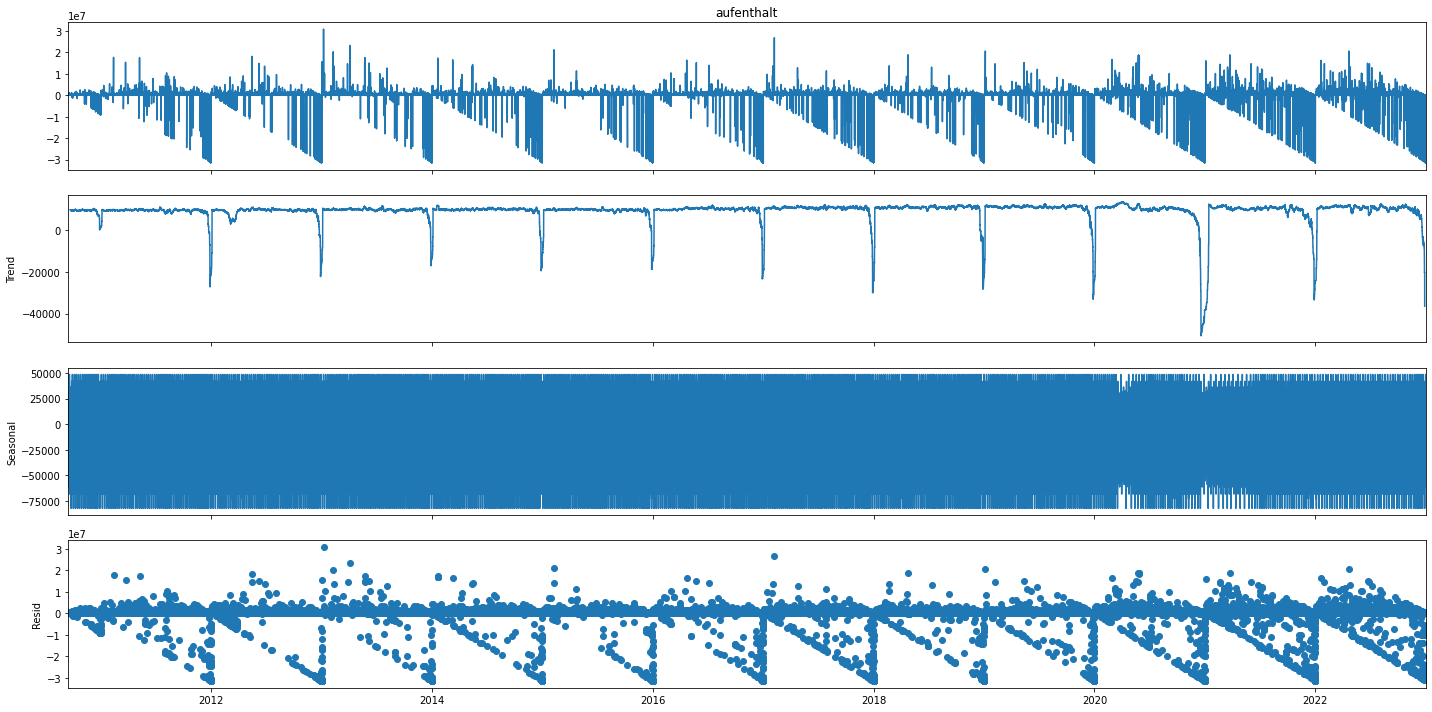

In [12]:
plt.rcParams["figure.figsize"] = (20,10)

df_temp.index = df_temp['ts_'+periodicity]

period = int(df_result[df_result['density'] == periodicity]['distincts'].item()/2)
result = seasonal_decompose(df_temp['aufenthalt'], model='additive',period=int(98630/2))
result.plot()
plt.show()

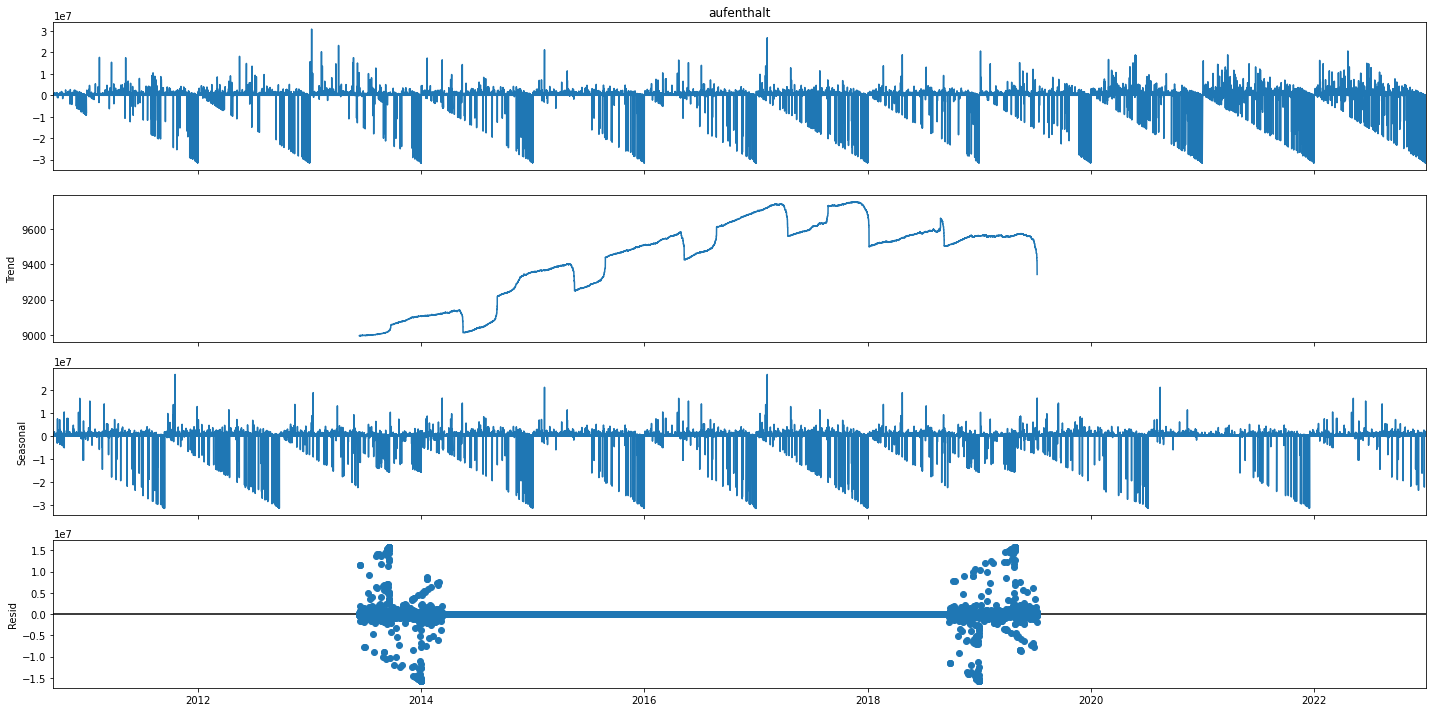

In [7]:
plt.rcParams["figure.figsize"] = (20,10)

df_temp.index = df_temp['ts_'+periodicity]

period = int(df_result[df_result['density'] == periodicity]['distincts'].item()/2)
result = seasonal_decompose(df_temp['aufenthalt'], model='additive',period=period)
result.plot()
plt.show()

In [9]:
df_sd = pd.DataFrame()
df_sd['res'] = result.resid
df_sd['trend'] = result.trend
df_sd['seasonal'] = result.seasonal

In [10]:
df_sd[~df_sd['trend'].isna()]

,res,trend,seasonal
ts_s,,,
2013-06-12 14:56:24,-14097.959831,8994.160714,9701.799116
2013-06-12 14:56:27,-72.459693,8994.160676,-605.700983
2013-06-12 14:56:36,3540.040828,8994.160861,3287.798311
2013-06-12 14:56:38,334.041259,8994.160894,-7021.202152
2013-06-12 14:56:52,2529.541542,8994.160383,368.298075
...,...,...,...
2019-07-09 15:59:21,1857.700121,9342.593852,-4804.293973
2019-07-09 15:59:21,442.700472,9342.593520,-2541.293992
2019-07-09 15:59:25,931.700655,9342.593293,-3985.293948


In [ ]:
bla = " ".join(df['deliveryCity'])[:100000]
bla

In [ ]:
import nltk
from nameparser.parser import HumanName
from nltk.corpus import wordnet


person_list = []
person_names=person_list
def get_human_names(text):
    tokens = nltk.tokenize.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    sentt = nltk.ne_chunk(pos, binary = False)

    person = []
    name = ""
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON'):
        for leaf in subtree.leaves():
            person.append(leaf[0])
        if len(person) > 1: #avoid grabbing lone surnames
            for part in person:
                name += part + ' '
            if name[:-1] not in person_list:
                person_list.append(name[:-1])
            name = ''
        person = []
#     print (person_list)

In [ ]:
names = get_human_names(text)
for person in person_list:
    person_split = person.split(" ")
    for name in person_split:
        if wordnet.synsets(name):
            if(name in person):
                person_names.remove(person)
                break

print(person_names)

In [196]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

def check_location(text):
    st = StanfordNERTagger(
        '/media/daniel/m2ssd/nitd/english.all.3class.distsim.crf.ser.gz',
		'/media/daniel/m2ssd/nitd/stanford-ner-2017-06-09/stanford-ner-3.8.0.jar',
		encoding='utf-8'
    )
    for sent in nltk.sent_tokenize(text):
        tokens = nltk.tokenize.word_tokenize(sent)
        tags = st.tag(tokens)
        for tag in tags:
            if tag[1] in ["PERSON", "LOCATION", "ORGANIZATION"]:
                return tag[1]
    return "none"

In [208]:
df_postal = pd.DataFrame()

for col in list(df_types[df_types['type']=='string']['attribute']):
    print(col)
    colValue = " ".join(df[col].unique())[:100000]
    contentFlag = None
    contentCheckResult = check_location(colValue)
    print(contentCheckResult)
    if(contentCheckResult in ["PERSON", "LOCATION", "ORGANIZATION"]):
        contentFlag = contentCheckResult
    else:
        contentFlag = None
    df_postal = df_postal._append({
        'attribute': col,
        'contains': contentFlag
    },ignore_index=True)


externalReference
none
pickupCity
LOCATION
pickupCountry
none
pickupName
PERSON
key.1
none
deliveryCity
ORGANIZATION
deliveryCountry
none
deliveryName
PERSON
departmentKey
none
customerKey
none
product
none
type
none
CarrierName
ORGANIZATION
ShipperName
ORGANIZATION
Pickup-NUTS-1-Name
PERSON
Pickup-NUTS-1-ID
none
Delivery-NUTS-1-Name


KeyboardInterrupt: 

In [138]:
text="Bonn, Rosental 32"
print(text+" - "+check_location(text))

text="I am looking for a place to stay."
print(text+" - "+check_location(text))

Bonn, Rosental 32 - True
I am looking for a place to stay. - False


In [120]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/daniel/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [22]:
pd.infer_freq(df_temp.index)

In [52]:
pd.to_timedelta(np.diff(df_temp.index).max())

Timedelta('3 days 00:00:00')

In [ ]:
plot=sns.pairplot(df6)
plot.savefig("/home/daniel/training_scripts/serie-a/pairplot.png")

In [ ]:

import holoviews as hv
from holoviews import opts, dim
import plotly.graph_objects as go
import plotly.express as pex

In [ ]:
hv.extension('bokeh')